# Анализ датасета *Fetch California Housing*

- ## Работа с выбросами, корреляцией; математические преобразования признаков;

- ## Оценка важности предварительной работы с данными.

In [88]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error  # for RMSE
from sklearn.metrics import r2_score  # R2

## 1. Загрузка датасета

In [89]:
bunch = fetch_california_housing(as_frame=True)  # Загружаем данные сразу в формате Pandas df
print(bunch.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Прочитав описание, делаем вывод, что целевая переменная - среднее значение стоимости жилья для определённого района

In [90]:
df = bunch.data
df[bunch.target_names[0]] = bunch.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. Первичный анализ датасета

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Видим, что в датасете нет пропущенных значений (*и это замечательно*).
Все признаки представлены численными значениями.

In [92]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## 3. Обучение модели на *сырых* данных

Напишем функцию для обучения модели и вычисления метрик качества

In [93]:
def get_score(data, model, random_state=42):
    """ 
    Обучение модели LinReg;
    вычисление метрик RMSE, R2 
    """
    model = model()
    X = data[data.columns[:-1]]
    y = data[bunch.target_names[0]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state) 
    model.fit(X_train, y_train)

    p_train, p_test = model.predict(X_train), model.predict(X_test)

    results = np.array([
        ['train', mean_squared_error(y_train, p_train, squared=False), r2_score(y_train, p_train)],
        ['test', mean_squared_error(y_test, p_test, squared=False), r2_score(y_test, p_test)],
    ])  

    return pd.DataFrame(results, columns=['dataset', 'RMSE', 'R2']).set_index('dataset')

In [94]:
# Результат на неподготовленных данных
get_score(
    data=df,
    model = LinearRegression
)

,RMSE,R2
dataset,,
train,0.7196757085831575,0.6125511913966952
test,0.7455813830127763,0.575787706032451


## 4. Анализ целевой переменной

Посмотрим на гистограмму:

<AxesSubplot:>

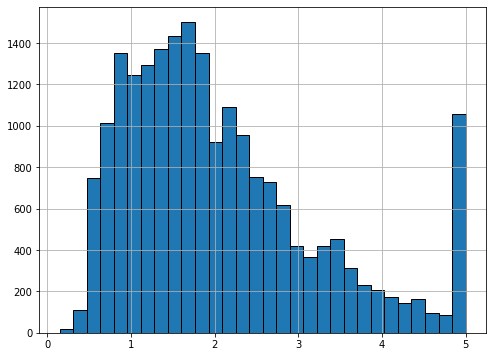

In [95]:
bunch.target.hist(figsize=(8, 6), bins=30, edgecolor="black")

Видим, что распределение стоимости в целом равномерное, но отметке **5** соответствует неожиданно большое количество наблюдений. Можно сделать вывод, что значение *$500,000 (5)* - намеренно установленный порог, и все дорогостоящие дома получили это (одинаковое) значение. Проверим это:

In [96]:
df[df['MedHouseVal'] > 5].MedHouseVal.head()

89 5.00001
459 5.00001
493 5.00001
494 5.00001
509 5.00001
Name: MedHouseVal, dtype: float64

Действительно, почти тысяча домов получили одно и то же значение - максимально возможное. 

## 5. Корреляционная матрица

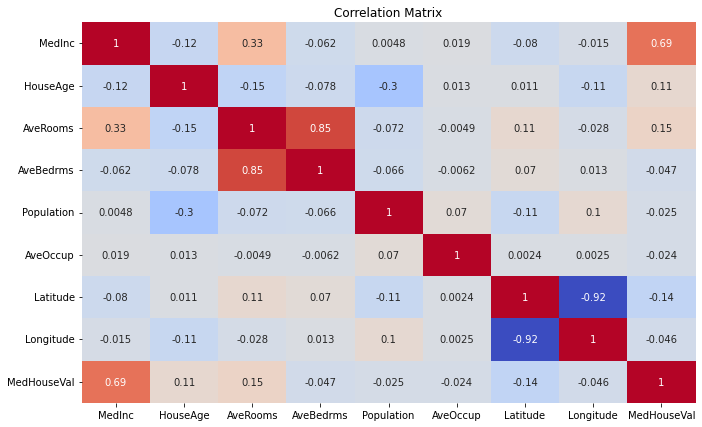

In [97]:
plt.figure(figsize=(11,7))
sns.heatmap(cbar=False,annot=True,data=df.corr(),cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Матрица позволяет сделать следующие выводы:

- **Широта и долгота сильно коррелируют между собой ввиду *географических* особенностей штата *Калифорния*. Эта корреляция обратная; попробуем удалить один из признаков.**

In [98]:
# Убираем широту и обучаем модель
get_score(
    df.drop(columns=['Latitude']), LinearRegression
)

,RMSE,R2
dataset,,
train,0.7780221694598236,0.5471810575363253
test,0.8010837880530353,0.5102786640374906


Результат ухудшился. Для дальнейших расчётов оставим оба столбца.

- **Целевая переменная сильно коррелирует со *значением среднего дохода (первый столбец)*, что вполне логично: чем больше денег, тем более дорогое жильё можно себе позволить. Этот столбец наиболее важен для точного предсказания (пока ничего делать с ним не будем)**

- **Среднее количество комнат сильно коррелирует с числом спальных комнат. Здесь закономерность тоже очевидна: чем больше комнат в целом, тем, вероятнее, больше будет и конкретных комнат. Оставим только среднее число всех комнат**

In [99]:
# Удаляем число спальных комнат
df.drop(columns=['AveBedrms'], inplace=True)
get_score(df, LinearRegression)

,RMSE,R2
dataset,,
train,0.7316746485880744,0.5995238502055928
test,0.7398151789804083,0.5823239094526445


Метрики модели ухудшились для обучающей выборки, но стали лучше для тестовой - значит, удаление признака снизило переобучение модели. Оставим эти метрики как конечный результат применения корреляционной матрицы.

## 6. Исследование выбросов

#### Боксплоты

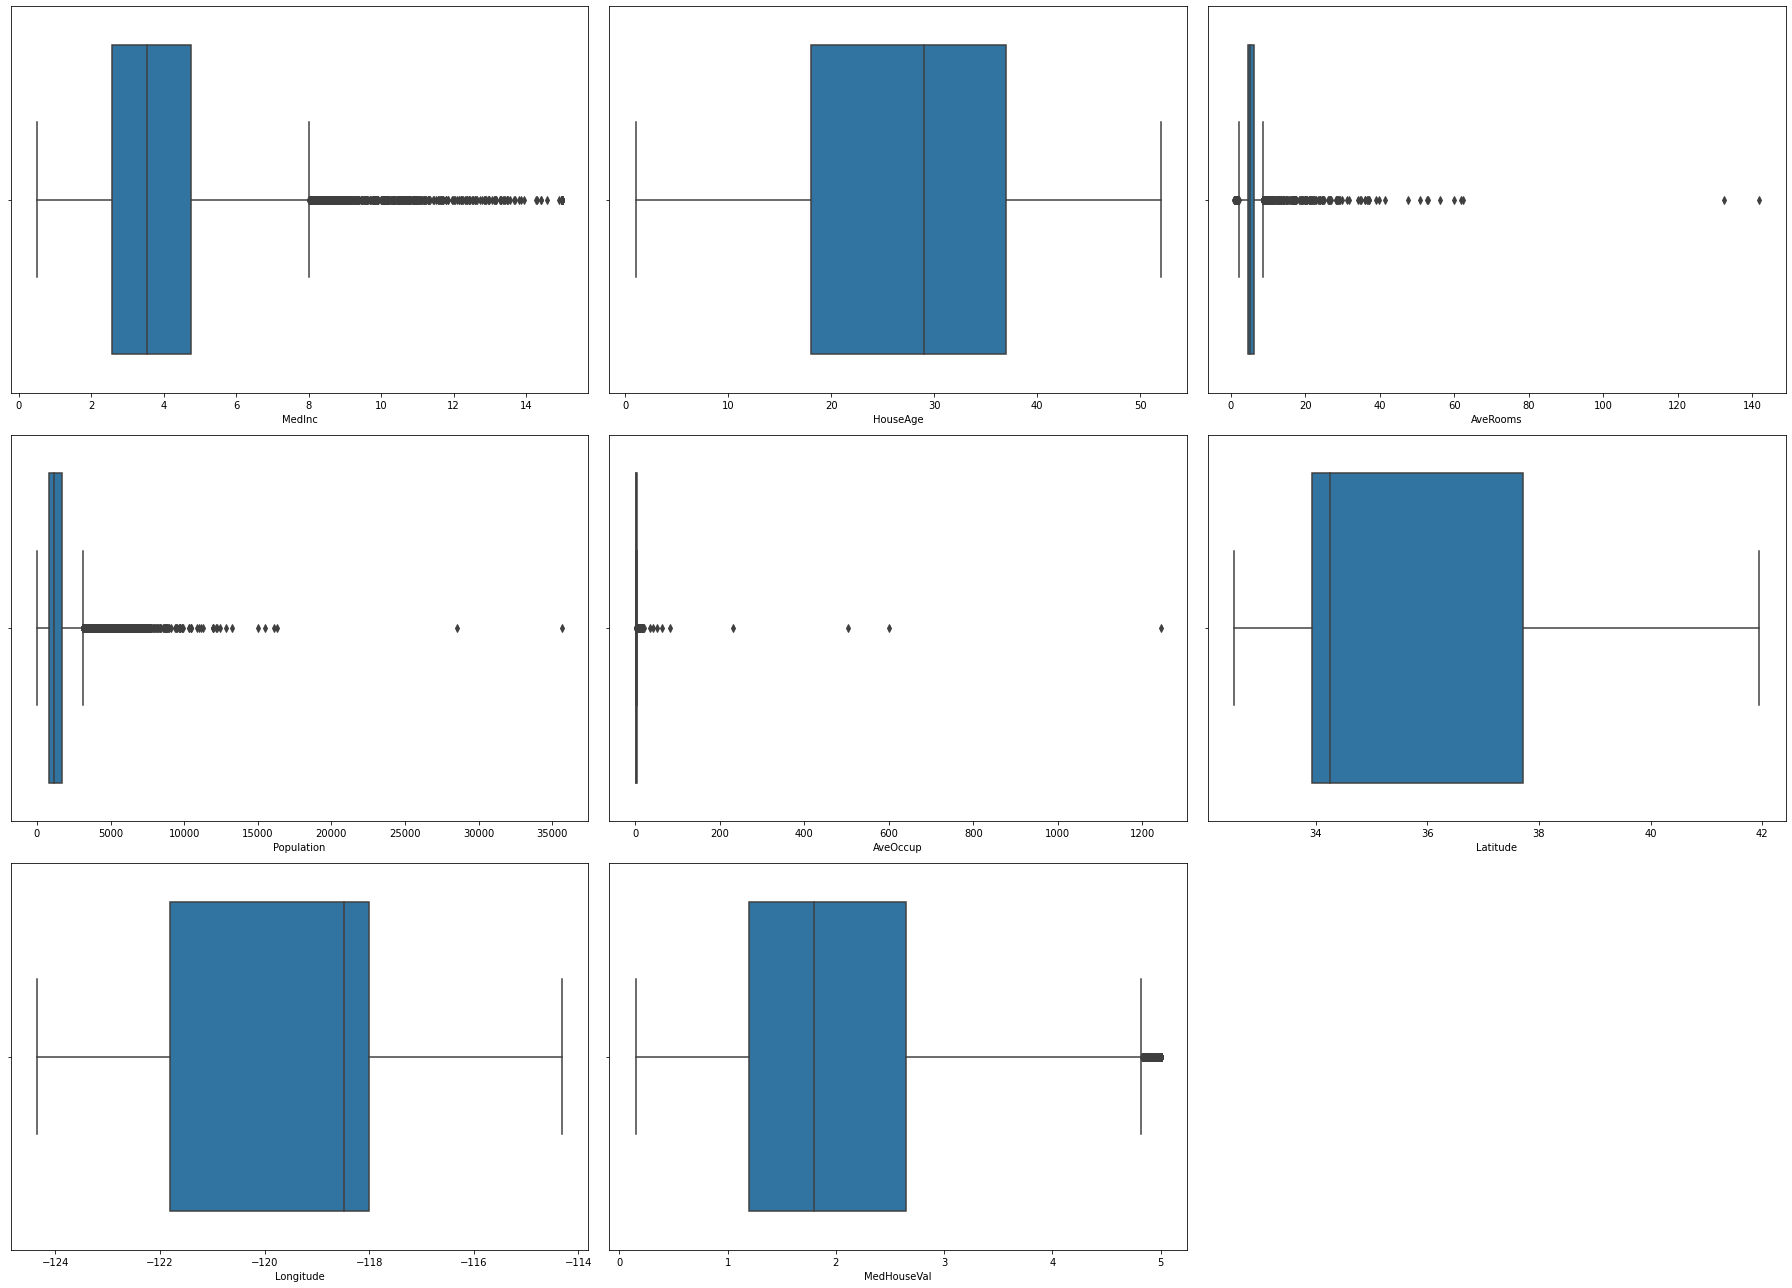

In [100]:
# Отобразим ящики с усами
fig = plt.figure(figsize = (25,18))

for i, column in enumerate(df.columns):
    ax = fig.add_subplot(3, 3, i+1)
    sns.boxplot(x = df[column],ax=ax)
fig.tight_layout()

#### Гистограммы

array([[%lt;AxesSubplot:title={'center':'MedInc'}%gt;,
 %lt;AxesSubplot:title={'center':'HouseAge'}%gt;,
 %lt;AxesSubplot:title={'center':'AveRooms'}%gt;],
 [%lt;AxesSubplot:title={'center':'Population'}%gt;,
 %lt;AxesSubplot:title={'center':'AveOccup'}%gt;,
 %lt;AxesSubplot:title={'center':'Latitude'}%gt;],
 [%lt;AxesSubplot:title={'center':'Longitude'}%gt;, %lt;AxesSubplot:%gt;,
 %lt;AxesSubplot:%gt;]], dtype=object)

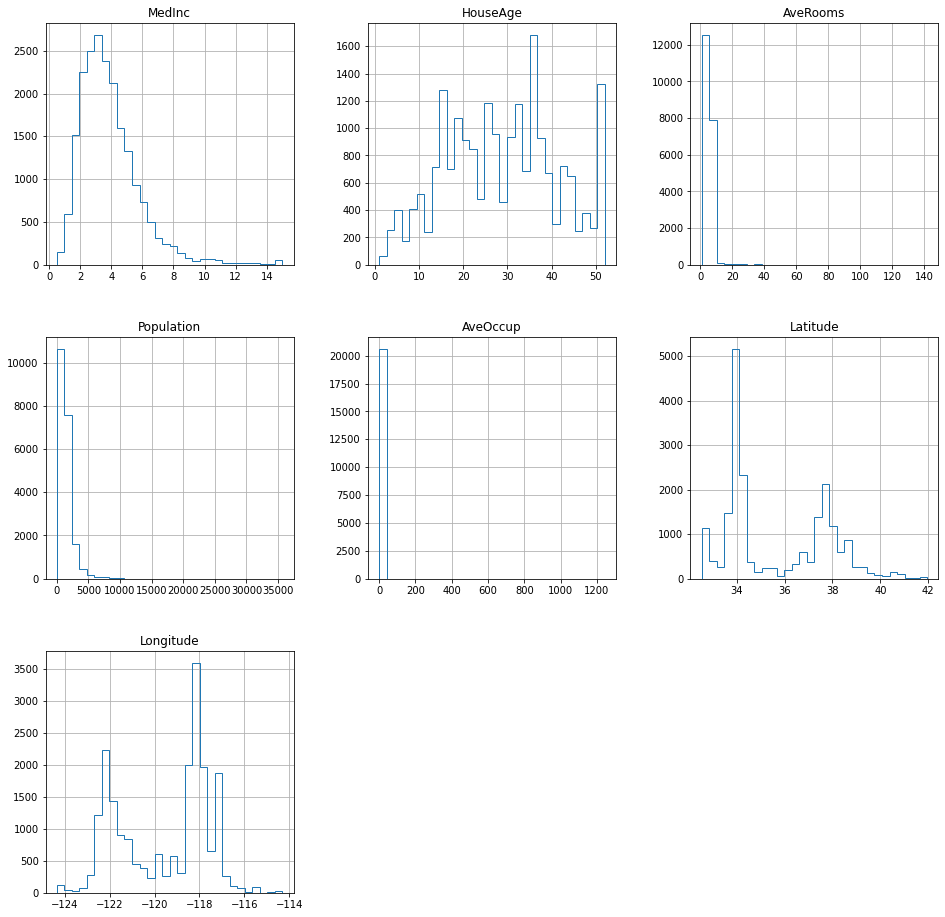

In [101]:
df[df.columns[:-1]].hist(histtype='step', figsize=(16, 16), bins=30)

#### Удаление выбросов

1) Количество комнат


In [102]:
df = df[df.AveRooms < 80]
get_score(df, LinearRegression)

,RMSE,R2
dataset,,
train,0.7322592369872835,0.5975476886587814
test,0.7362716004436051,0.5913655345464535


2. Население блока

In [103]:
df = df[df.Population < 8000]
get_score(df, LinearRegression)

,RMSE,R2
dataset,,
train,0.7377670094954035,0.5919077594049078
test,0.7170288389975801,0.6133497069725524


3. Household members

В этом столбце *межквартильный размах* очень узкий, поэтому выбросы мы "обрежем" почти полностью - при сравнении это даёт лучший результат.

In [104]:
df = df[df.AveOccup < 10]
get_score(df, LinearRegression)

,RMSE,R2
dataset,,
train,0.6800217667536742,0.6550013909003375
test,0.6932463230095822,0.630251571437026


Видим, что удаление выбросов позволило улучшить результат.

## 7. Математические преобразования признаков

#### 1. Логарифмирование

Прологарифмируем признаки с очень узким межквартильным размахом

array([[%lt;AxesSubplot:title={'center':'AveOccup'}%gt;,
 %lt;AxesSubplot:title={'center':'AveRooms'}%gt;]], dtype=object)

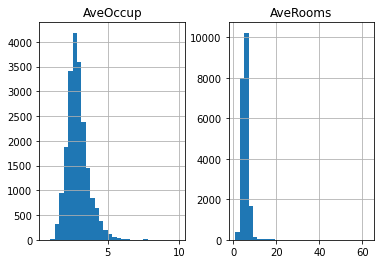

In [105]:
# Ещё раз посмотрим на них до преобразования
df[['AveOccup', 'AveRooms']].hist(bins=30)

In [106]:
df['AveOccup'] = np.log(df['AveOccup'])
get_score(df, LinearRegression)

,RMSE,R2
dataset,,
train,0.6678401369463359,0.6672510079420719
test,0.6812779196582969,0.6429082516850778


In [107]:
df['AveRooms'] = np.log(df['AveRooms'])
get_score(df, LinearRegression)

,RMSE,R2
dataset,,
train,0.6685784875469253,0.6665148400571056
test,0.6809428296598276,0.6432594400702538


array([[%lt;AxesSubplot:title={'center':'AveOccup'}%gt;,
 %lt;AxesSubplot:title={'center':'AveRooms'}%gt;]], dtype=object)

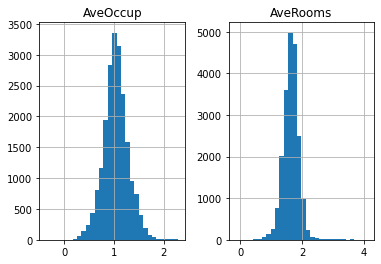

In [108]:
# Посмотрим, как данные распределены теперь
df[['AveOccup', 'AveRooms']].hist(bins=30)

Была также попытка логарифрировать Population, но это привело к ухудшению результата.

#### 2. Бинаризация

Признак "Доход", имеющий пороговое значение *15*, хорошо коррелирует с целевой переменной, у которой тоже есть пороговое значение.

In [109]:
print(df[df['MedInc'] >= 15]['MedHouseVal'].describe())
df[df['MedInc'] >= 15][['MedInc', 'MedHouseVal']].head()

count    50.000000
mean      4.876269
std       0.572829
min       1.313000
25%       5.000010
50%       5.000010
75%       5.000010
max       5.000010
Name: MedHouseVal, dtype: float64


,MedInc,MedHouseVal
1566,15.0001,3.50000
4352,15.0001,5.00001
4604,15.0001,5.00001
4605,15.0001,5.00001
4606,15.0001,5.00001


Видим, что в том случае, если доход достигает порога, цена жилья практически гарантированно (96%) так же имеет максимальное значение. 

Тогда введём отдельный признак, показывающий, превышает ли доход $15000:

In [110]:
df.insert(1, 'HighInc', df['MedInc'] >= 15)
df['HighInc'] = df.HighInc.astype('int64')  # Меняем True/False на 1/0

get_score(df, LinearRegression)

,RMSE,R2
dataset,,
train,0.6632002163556575,0.6718585943227673
test,0.6759787800874816,0.6484417341724794


## 8. Выводы

В ходе работы с данными были проделаны следующие преобразования:

**1) На основании *корреляционной матрицы* были отброшены данные, способствующие переобучению модели;**

**2) Были удалены выбросы;**

**3) Были проведены математические преобразования признаков.**

Всё это позволило улучшить качество модели: RMSE метрика уменьшилась, а R2 увеличилась:

In [111]:
def show_results(rmse, r2):
    """ Функция для отображения результатов работы. """
    return pd.DataFrame(np.array(
        [
        ['raw data', rmse[0], r2[0]],
        ['correlation, %', round(100*(rmse[1] - rmse[0]), 2), round(100*(r2[1] - r2[0]), 2)],
        ['outliers, %', round(100*(rmse[2] - rmse[0]), 2), round(100*(r2[2] - r2[0]), 2)],
        ['math, %', round(100*(rmse[3] - rmse[0]), 2), round(100*(r2[3] - r2[0]))],
        ['final', rmse[3], r2[3]]
        ]), 
        columns=['step', 'RMSE', 'R2']).set_index('step')

In [112]:
show_results([0.7455813830127763, 0.7398151789804083, 0.6932463230095822, 0.6759787800874816], 
[0.575787706032451, 0.5823239094526445, 0.630251571437026, 0.6484417341724794])

,RMSE,R2
step,,
raw data,0.7455813830127763,0.575787706032451
"correlation, %",-0.58,0.65
"outliers, %",-5.23,5.45
"math, %",-6.96,7
final,0.6759787800874816,0.6484417341724794


#### Результат работы:

Поставленная задача была полностью выполнена. Были опробованы различные способы обработки данных, после чего была оценена эффективность способов. Каждый подход позволил в той или иной степени улучшить качество предсказаний:
суммарно обе метрики улучшились примерно на 7%.